# Methods
- hta 2.0 array processed data was downloaded from exon.ucsc.edu. Significant events were described using a q-value cutoff of 0.05. Inclusion sepscore cutoffs of 0.5 and -0.5 were used to describe splicing inclusion, exclusion, and unchanged events. Additionally, complex events (instances where an event is multiply classified) and events which lie on noncanonical chromosomes were filtered. 
- To classify 'weak', 'medium', and 'strongly' spliced events, absolute sepscore cutoffs of 0.5 < 1, 1 < 1.5, and 1.5+ were used. 

In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import copy
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

# Figure 3b - Cassette Exon Behavior

In [2]:
date = "6-6-2017"
exon_or_event = "exon" # if "exon", we're using the inclredo.csv, since that file contains the cassette exon. This file also only contains cassettes.

sep_score_threshold = 0.5
p_val_threshold = 0.05
# all_data = '/home/bay001/projects/tbos_splicing_20160203/permanent_data/all_tbos_data.csv' # downloaded from exon.ucsc.edu ## REPLACED WITH INCLREDO.CSV
# event_cols = ['Gene','path','event position','event name','notes'] # if downloading from exon.ucsc.edu
event_cols = ['chrom','exon_start','exon_end','nice_name','0','strand','uniq_name','Gene','path','event position','event name','notes']
all_data = '/projects/ps-yeolab3/bay001/tbos/inclredo.csv' # formerly /home/bay001/projects/tbos_splicing_20160203/permanent_data/inclredo.csv
event_centric_dir = '/home/bay001/projects/tbos_splicing_20160203/data/temp/{}'.format(date)
exon_centric_dir = '/home/bay001/projects/tbos_splicing_20160203/data/temp/{}'.format(date)


if not os.path.exists(event_centric_dir):
    ! mkdir $event_centric_dir
if not os.path.exists(exon_centric_dir):
    ! mkdir $exon_centric_dir

In [3]:
df = pd.read_table(all_data)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Filter out all the extra stuff, just want q-value, position, and sepscore
def filter_out_weird_chroms_and_unimportant_cols(df, col_prefix='hta_sepscore_yeo_aug15_all_', event_cols=event_cols):
    """
    Filters out the weird chroms (hap scaff) and returns only the 
    
    Returns conditions: list
        List of conditions (usually each prefixed to 6-7 columns)
    Returns df: pandas.DataFrame()
        DataFrame of events as rows and associated sepscores and qvalues as columns
    """
    df = df[df['event position'].str.contains('chr[XY\d]+\:')==True] # remove noncanonical chromosomes (chr6_hap etc.)
    df = df[df['notes']!='complex '] # remove 'complex' events from the equation
    df['notes'] = df['notes'].replace(' ','') # removes that annoying extra space that is in the notes section.
    print("num events: ",df.shape[0])
    dfx = df.filter(regex=("^hta_sepscore"))
    conditions = [] # the conditions (apobec4_over, apobec4_kd, etc.)
    cols_to_keep = copy.copy(event_cols) # keep only the columns with the above prefix (grab all cols if col_prefix is none)

    for column in dfx.columns:
        if column.endswith("_sepscore"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)

        elif column.endswith("_q-value"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)
                conditions.append(
                    column.replace('_q-value','').replace('hta_sepscore_yeo_aug15_all_','')
                )
    df = df[cols_to_keep]
    return conditions, df

def build_sepscore_dict(conditions, df, col_prefix='hta_sepscore_yeo_aug15_all_'):
    # Further separate by individual condition (apobec4_over, apobec4_kd, etc.)
    scores = {}
    y = tnrange(len(conditions))
    for condition in conditions:
        cols_to_keep = copy.copy(event_cols)
        sepscore_col = col_prefix + condition + '_sepscore'
        qvalue_col = col_prefix + condition + '_q-value'
        cols_to_keep.append(sepscore_col)
        cols_to_keep.append(qvalue_col)
        df[qvalue_col].fillna(1,inplace=True) # fill p-value nans with 1
        df[sepscore_col].fillna(0,inplace=True) # fill sepscore nans with 0

        included = df[
            (df[qvalue_col] < p_val_threshold) & (df[sepscore_col] > sep_score_threshold)
        ]
        included = included[cols_to_keep]

        excluded = df[
            (df[qvalue_col] < p_val_threshold) & (df[sepscore_col] < -sep_score_threshold)
        ]
        excluded = excluded[cols_to_keep]

        unchanged = df[
            (df[qvalue_col] < p_val_threshold) & 
            (df[sepscore_col] >= -sep_score_threshold) & 
            (df[sepscore_col] <= sep_score_threshold)
        ]
        unchanged = unchanged[cols_to_keep]

        scores[condition] = {
            'included':included,
            'excluded':excluded,
            'unchanged':unchanged
        }
        y.update(1)
    return scores

In [5]:
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df)
scores = build_sepscore_dict(conditions, df)

('num events: ', 8046)


Widget Javascript not detected.  It may not be installed or enabled properly.


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


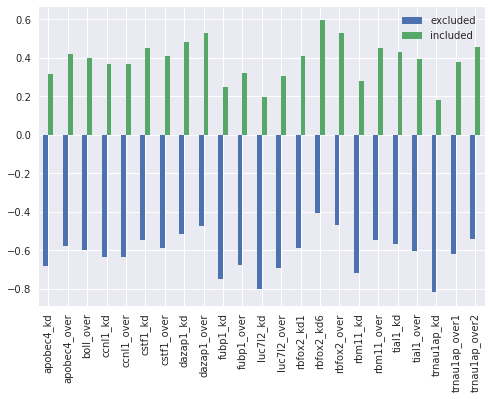

In [6]:
# num significant events:
strength = defaultdict(dict)

for condition in sorted(scores.keys()):
    included_num = scores[condition]['included'].shape[0]
    excluded_num = scores[condition]['excluded'].shape[0]
    total_num = scores[condition]['included'].shape[0]+scores[condition]['excluded'].shape[0]
    strength[condition] = {
        'included':included_num/float(total_num),
        'excluded':-excluded_num/float(total_num),
    }
pd.DataFrame(strength).T.plot(kind='bar')

# Export sepscores as MISO-like events

In [7]:
MIN_CHROM = 1
MAX_CHROM = 300000000
y = tnrange(len(conditions))

def to_miso(row):
    chrom,pos,strand = row['event position'].split(':')
    pos1, pos2 = pos.split('-')
    
    if(strand == '-'):
        upstart = int(pos2) + 1
        upend = MAX_CHROM
        downstart = MIN_CHROM
        downend = pos1
    else:
        upstart = MIN_CHROM
        upend = pos1
        downstart = int(pos2) + 1
        downend = MAX_CHROM
    skipstart = int(row['exon_start']) + 1
    skipend = row['exon_end']
    return '{}:{}:{}:{}@{}:{}:{}:{}@{}:{}:{}:{}'.format(
    chrom,upstart,upend,strand,
    chrom,skipstart,skipend,strand,
    chrom,downstart,downend,strand)

for condition in sorted(scores.keys()):
    y.update(1)
    for sep_kind in ['included','excluded','unchanged']:
        df = scores[condition][sep_kind].copy()
        df['miso_string'] = df.apply(to_miso, axis=1)
        dfx = pd.concat([df['miso_string'],df['uniq_name']],axis=1)
        out_file = os.path.join(
            exon_centric_dir,"{}.{}.sep_{}.p_{}.tsv".format(
                condition, sep_kind, sep_score_threshold, p_val_threshold
            )
        )
        dfx.to_csv(out_file,sep='\t',index=None,header=None)

Widget Javascript not detected.  It may not be installed or enabled properly.


# Figure 3b - % Total Events

In [8]:
all_data = '/home/bay001/projects/tbos_splicing_20160203/permanent_data/all_tbos_data.csv' # downloaded from exon.ucsc.edu ## REPLACED WITH INCLREDO.CSV
event_cols = ['Gene','path','event position','event name','notes'] # if downloading from exon.ucsc.edu

In [9]:
df = pd.read_table(all_data)
df = df[df['path']=='in'] # avoid double counting the 'sk' and 'in' for the same event.
print("num events: ",df.shape[0])

('num events: ', 29653)


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,11,12,18,19,25,26,32,33,40,47,54,61,68,75,82,89,96,103,110,117,124,131,138,145,152,208) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
scores['trnau1ap_kd']['excluded']['notes'].value_counts().add(scores['trnau1ap_kd']['included']['notes'].value_counts(), fill_value=0)

alt_cassette     352
Name: notes, dtype: int64

In [11]:
print(df.columns)
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df, event_cols=event_cols)
scores = build_sepscore_dict(conditions, df)

Index([u'Gene', u'path', u'event position', u'event name', u'notes',
       u'hta_sepscore_yeo_aug15_all_dazap1_over',
       u'hta_sepscore_yeo_aug15_all_dazap1_over_sepscore',
       u'hta_sepscore_yeo_aug15_all_dazap1_over_q-value',
       u'hta_sepscore_yeo_aug15_all_dazap1_over_skipA',
       u'hta_sepscore_yeo_aug15_all_dazap1_over_skipB',
       ...
       u'hta_sepscore_yeo_aug15_all_trnau1ap_kd_skipB',
       u'hta_sepscore_yeo_aug15_all_trnau1ap_kd_inclA',
       u'hta_sepscore_yeo_aug15_all_trnau1ap_kd_inclB ',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_sepscore',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_q-value',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_skipA',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_skipB',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_inclA',
       u'hta_sepscore_yeo_aug15_all_luc7l2_kd_inclB '],
      dtype='object', length=236)
('num events: ', 26310)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [12]:
merged = pd.DataFrame()
for condition in conditions:
    total_significant_events = \
        scores[condition]['included']['notes'].value_counts().add(
            scores[condition]['excluded']['notes'].value_counts(),
            fill_value=0
        )
        
    total_significant_events = pd.DataFrame(total_significant_events)
    total_significant_events.columns = [condition]
    merged = pd.merge(merged, total_significant_events, how='outer', left_index=True, right_index=True).fillna(0)

merged

,dazap1_over,rbfox2_over,tial1_over,luc7l2_over,rbfox2_kd6,cstf1_over,rbm11_kd,dazap1_kd,trnau1ap_over2,apobec4_over,...,boll_over,ccnl1_kd,tial1_kd,trnau1ap_over1,rbm11_over,rbfox2_kd1,apobec4_kd,fubp1_kd,trnau1ap_kd,luc7l2_kd
alt_3,96,32.0,256,49,177,92,59.0,220,74.0,308,...,332,69.0,128,259,110.0,145,418,55,65.0,127
alt_5,78,29.0,194,23,141,77,34.0,176,46.0,233,...,259,60.0,117,239,78.0,105,385,37,56.0,132
alt_cassette,720,98.0,1140,121,871,306,226.0,1218,223.0,1387,...,1530,337.0,688,1355,316.0,635,2273,327,352.0,831
alt_end,211,11.0,479,42,229,104,62.0,563,73.0,576,...,697,91.0,172,589,99.0,154,1153,74,125.0,261
alt_start,103,31.0,363,47,239,143,57.0,340,101.0,455,...,620,62.0,127,493,157.0,198,789,54,85.0,150
mutually_exc,6,0.0,11,2,10,4,1.0,7,1.0,13,...,10,0.0,3,9,2.0,8,20,3,1.0,6
retained_int,173,67.0,423,48,269,245,113.0,318,148.0,504,...,617,148.0,157,506,227.0,184,719,78,135.0,192
twin_cassett,26,5.0,42,6,36,11,7.0,42,8.0,56,...,69,7.0,19,56,17.0,24,78,8,11.0,29


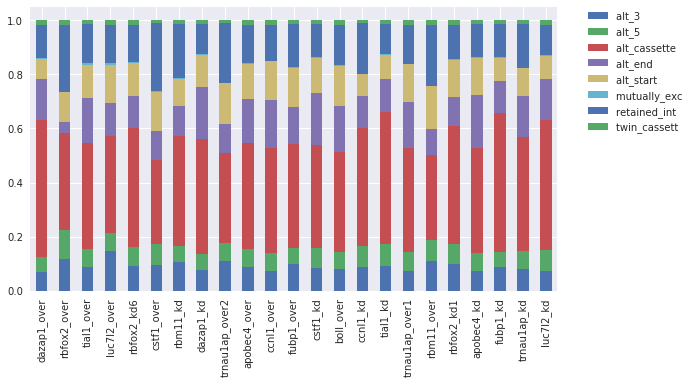

In [13]:
merged.div(merged.sum()).T.plot(kind='bar',stacked=True,legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# Get the overlap between KD and OVER sepscore events

In [14]:
over_to_kd = {
    'dazap1_over':'dazap1_kd',
    'rbfox2_over':'rbfox2_kd1',
    'tial1_over':'tial1_kd',
    'luc7l2_over':'luc7l2_kd',
    'cstf1_over':'cstf1_kd',
    'rbm11_over':'rbm11_kd',
    'apobec4_over':'apobec4_kd',
    'ccnl1_over':'ccnl1_kd',
    'trnau1ap_over1':'trnau1ap_kd',
    'fubp1_over':'fubp1_kd'
}
merge_on = ['event position','Gene','event name','notes']

for over, kd in over_to_kd.iteritems():
    total_over = pd.concat([scores[over]['included'], scores[over]['excluded']])
    total_kd = pd.concat([scores[kd]['included'], scores[kd]['excluded']])
    merged = pd.merge(total_over, total_kd, how='inner', on=merge_on)
    print(over, kd, merged.shape[0])

('cstf1_over', 'cstf1_kd', 262)
('luc7l2_over', 'luc7l2_kd', 42)
('ccnl1_over', 'ccnl1_kd', 341)
('rbm11_over', 'rbm11_kd', 51)
('dazap1_over', 'dazap1_kd', 380)
('tial1_over', 'tial1_kd', 378)
('rbfox2_over', 'rbfox2_kd1', 49)
('trnau1ap_over1', 'trnau1ap_kd', 276)
('fubp1_over', 'fubp1_kd', 64)
('apobec4_over', 'apobec4_kd', 1860)


# Figure 3b - Splicing evidence (number of events)

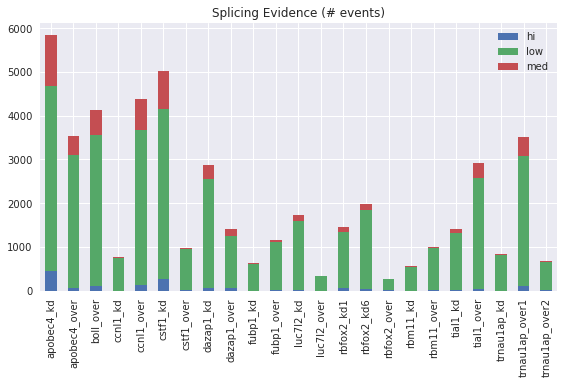

In [15]:
merged = {}
for condition in sorted(conditions):
    dfx = scores[condition]['included'].copy()
    dfy = scores[condition]['excluded'].copy()
    dfm = pd.concat([dfx, dfy])
    dfm.columns = ['Gene','path','event','name','notes','sepscore','qvalue']
    dfm['sepscore'] = abs(dfm['sepscore'])
    df_lo = dfm[
        (dfm['sepscore'] >= 0.5) & (dfm['sepscore'] < 1)
    ]
    df_med = dfm[
        (dfm['sepscore'] >= 1) & (dfm['sepscore'] < 1.5)
    ]
    df_hi = dfm[
        (dfm['sepscore'] >= 1.5)
    ]
    merged[condition] = {
        'low':df_lo.shape[0],
        'med':df_med.shape[0],
        'hi':df_hi.shape[0]
    }
merged = pd.DataFrame(merged).T
merged.plot(kind='bar',stacked=True)
plt.title('Splicing Evidence (# events)')
plt.tight_layout()

# look at overlap between exons that are included upon OE AND exons that are excluded upon KD:
- what is the overlap between exons whose splicing is promoted when the factor is over expressed, and the exons which are excluded when the factor is depleted?  is it significantly higher than expected?

In [16]:
event_cols = ['chrom','exon_start','exon_end','nice_name','0','strand','uniq_name','Gene','path','event position','event name','notes']
all_data = '/projects/ps-yeolab3/bay001/tbos/inclredo.csv' # formerly /home/bay001/projects/tbos_splicing_20160203/permanent_data/inclredo.csv

df = pd.read_table(all_data)
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df, event_cols=event_cols)
scores = build_sepscore_dict(conditions, df)


('num events: ', 8046)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [17]:
from collections import defaultdict

sep_threshold = 0.5
q_threshold = 0.05

significant_alt_spliced_exons = defaultdict(list)
kinda_significant_alt_spliced_exons = defaultdict(list)
all_alt_spliced_exons = defaultdict(list)

### This dictionary sets the pairings for each overexpression and knockdown condition
c = {'dazap1':{'over':['dazap1_over'], 'kd':['dazap1_kd']},
     'rbfox2':{'over':['rbfox2_over'], 'kd':['rbfox2_kd1']},
     'tial1':{'over':['tial1_over'], 'kd':['tial1_kd']},
     'cstf1':{'over':['cstf1_over'], 'kd':['cstf1_kd']},
     'rbm11':{'over':['rbm11_over'], 'kd':['rbm11_kd']},
     'trnau1ap':{'over':['trnau1ap_over1'], 'kd':['trnau1ap_kd']},
     'fubp1':{'over':['fubp1_over'], 'kd':['dazap1_kd']},
     'luc7l2':{'over':['luc7l2_over'], 'kd':['luc7l2_kd']},
     'apobec4':{'over':['apobec4_over'], 'kd':['apobec4_kd']},
     'ccnl1':{'over':['ccnl1_over'], 'kd':['ccnl1_kd']},
    }

### iterate over each RBP, select the relevant columns (sepscore and q-value) ###
### 
for rbp in c.keys():
    for o, k in zip(c[rbp]['over'], c[rbp]['kd']):
        over_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(o)
        over_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(o)
        kd_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(k)
        kd_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(k)

        dfx = df[[
            'chrom', 'exon_start', 'exon_end', 'strand',
            over_sep,
            over_q,
            kd_sep,
            kd_q
        ]]
        for _, row in dfx.iterrows():
            # if there is inclusion upon overexpression AND exclusion upon KD:
            if ((row[over_sep] > sep_threshold) and (row[kd_sep] < -sep_threshold)): 
                # If these values are significant in both
                if (row[over_q] < q_threshold) and (row[kd_q] < q_threshold):
                    significant_alt_spliced_exons[rbp].append(
                        '{}:{}-{}:{}'.format(
                            row['chrom'], row['exon_start'], row['exon_end'], row['strand']
                        )
                    )
                # If these values are just significant in one (kd) or the other (over)
                if (row[kd_q] < q_threshold) or (row[over_q] < q_threshold):
                    kinda_significant_alt_spliced_exons[rbp].append(
                        '{}:{}-{}:{}'.format(
                            row['chrom'], row['exon_start'], row['exon_end'], row['strand']
                        )
                    )
                # If these values are just alternatively spliced 
                all_alt_spliced_exons[rbp].append(
                    '{}:{}-{}:{}'.format(
                        row['chrom'], row['exon_start'], row['exon_end'], row['strand']
                    )
                )
                

In [18]:
pd.DataFrame(significant_alt_spliced_exons['apobec4'])

,0
0,chr4:141347857-141347941:-
1,chr5:132358532-132358598:-
2,chr11:113677210-113677306:-
3,chr12:107262078-107262201:+
4,chr10:77058709-77058832:+
5,chr16:15180221-15180311:-
6,chr16:29095763-29095853:+
7,chr17:18211664-18211738:-
8,chrX:41481869-41481887:-
9,chr17:35880281-35880317:-


In [19]:
for rbp, exons in kinda_significant_alt_spliced_exons.iteritems():
    print(rbp, len(exons))

('ccnl1', 9)
('dazap1', 106)
('trnau1ap', 20)
('rbfox2', 14)
('fubp1', 23)
('cstf1', 27)
('tial1', 46)
('apobec4', 19)
('luc7l2', 14)


In [20]:
for rbp, exons in all_alt_spliced_exons.iteritems():
    print(rbp, len(exons))

('ccnl1', 9)
('dazap1', 108)
('trnau1ap', 20)
('rbfox2', 15)
('fubp1', 25)
('cstf1', 29)
('rbm11', 2)
('tial1', 47)
('apobec4', 19)
('luc7l2', 15)


In [21]:
dx = pd.read_table(all_data)
dx = dx[['hta_sepscore_yeo_aug15_all_ccnl1_over_sepscore',
    'hta_sepscore_yeo_aug15_all_ccnl1_over_q-value',
    'hta_sepscore_yeo_aug15_all_ccnl1_kd_sepscore',
    'hta_sepscore_yeo_aug15_all_ccnl1_kd_q-value']]

dx[
    (dx['hta_sepscore_yeo_aug15_all_ccnl1_over_sepscore']> 0.5) &
    (dx['hta_sepscore_yeo_aug15_all_ccnl1_kd_sepscore']< -0.5)
]


,hta_sepscore_yeo_aug15_all_ccnl1_over_sepscore,hta_sepscore_yeo_aug15_all_ccnl1_over_q-value,hta_sepscore_yeo_aug15_all_ccnl1_kd_sepscore,hta_sepscore_yeo_aug15_all_ccnl1_kd_q-value
63,0.555,0.008,-0.793,0.104
1477,0.504,0.000,-0.620,0.000
1819,0.529,0.000,-0.604,0.119
1830,0.607,0.013,-0.633,0.278
2161,0.887,0.000,-0.566,0.000
3211,0.835,0.000,-0.507,0.112
3526,0.578,0.000,-0.629,0.394
4212,1.463,0.000,-0.972,0.000
5631,0.525,0.000,-0.561,0.060


In [66]:
event_cols = ['chrom','exon_start','exon_end','nice_name','0','strand','uniq_name','Gene','path','event position','event name','notes']
all_data = '/projects/ps-yeolab3/bay001/tbos/inclredo.csv' # formerly /home/bay001/projects/tbos_splicing_20160203/permanent_data/inclredo.csv

df = pd.read_table(all_data)
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df, event_cols=event_cols)
scores = build_sepscore_dict(conditions, df)


('num events: ', 8046)


In [69]:
from collections import defaultdict

sep_threshold = 0.00000001 # 0.5
q_threshold = 1 # 0.05

significant_alt_spliced_exons = defaultdict(list)
kinda_significant_alt_spliced_exons = defaultdict(list)
all_alt_spliced_exons = defaultdict(list)

### This dictionary sets the pairings for each overexpression and knockdown condition
c = {'dazap1':{'over':['dazap1_over'], 'kd':['dazap1_kd']},
     'rbfox2':{'over':['rbfox2_over'], 'kd':['rbfox2_kd1']},
     'tial1':{'over':['tial1_over'], 'kd':['tial1_kd']},
     'cstf1':{'over':['cstf1_over'], 'kd':['cstf1_kd']},
     'rbm11':{'over':['rbm11_over'], 'kd':['rbm11_kd']},
     'trnau1ap':{'over':['trnau1ap_over1'], 'kd':['trnau1ap_kd']},
     'fubp1':{'over':['fubp1_over'], 'kd':['dazap1_kd']},
     'luc7l2':{'over':['luc7l2_over'], 'kd':['luc7l2_kd']},
     'apobec4':{'over':['apobec4_over'], 'kd':['apobec4_kd']},
     'ccnl1':{'over':['ccnl1_over'], 'kd':['ccnl1_kd']},
    }

### iterate over each RBP, select the relevant columns (sepscore and q-value) ###
### 
for rbp in c.keys():
    for o, k in zip(c[rbp]['over'], c[rbp]['kd']):
        over_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(o)
        over_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(o)
        kd_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(k)
        kd_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(k)

        dfx = df[[
            'Gene', 'path', 'event position', 'event name',
            over_sep,
            over_q,
            kd_sep,
            kd_q
        ]]
        for _, row in dfx.iterrows():
            # if there is inclusion upon overexpression AND exclusion upon KD:
            if ((row[over_sep] > sep_threshold) and (row[kd_sep] < -sep_threshold)): 
                # If these values are significant in both
                if (row[over_q] < q_threshold) and (row[kd_q] < q_threshold):
                    significant_alt_spliced_exons[rbp].append(
                        '{}:{}-{}:{}'.format(
                            row['Gene'], row['path'], row['event position'], row['event name']
                        )
                    )
                # If these values are just significant in one (kd) or the other (over)
                if (row[kd_q] < q_threshold) or (row[over_q] < q_threshold):
                    kinda_significant_alt_spliced_exons[rbp].append(
                        '{}:{}-{}:{}'.format(
                            row['Gene'], row['path'], row['event position'], row['event name']
                        )
                    )
                # If these values are just alternatively spliced 
                all_alt_spliced_exons[rbp].append(
                    '{}:{}-{}:{}'.format(
                        row['Gene'], row['path'], row['event position'], row['event name']
                    )
                )
                

In [134]:
import seaborn as sns
from collections import defaultdict
# sns.set_style('white')

def subset_dataframe_and_plot_dpsi(rbp, c):
    for o, k in zip(c[rbp]['over'], c[rbp]['kd']):
        over_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(o)
        over_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(o)
        kd_sep = 'hta_sepscore_yeo_aug15_all_{}_sepscore'.format(k)
        kd_q = 'hta_sepscore_yeo_aug15_all_{}_q-value'.format(k)

        dfx = df[[
            over_sep,
            over_q,
            kd_sep,
            kd_q
        ]]
        dfx.columns=['over','overq','kd','kdq']
    return dfx

def plot(dfx, outdir, rbpname):
    fig, ax = plt.subplots(figsize=(10,10))
    
    all_events = dfx
    ax.scatter(
        all_events['over'], 
        all_events['kd'],
        label='all events (n={})'.format(all_events.shape[0]),
        alpha=0.3,
    )

    dpsi_diff = dfx[(dfx['over']-dfx['kd']>0.5)]
    ax.scatter(
        dpsi_diff['over'],
        dpsi_diff['kd'],
        label='over - kd > 0.5 dpsi (n={})'.format(dpsi_diff.shape[0]),
        alpha=0.5
    )
    
    dpsi_events = dfx[(dfx['over']>0.5) & (dfx['kd']<-0.5)]
    ax.scatter(
        dpsi_events['over'],
        dpsi_events['kd'],
        label='over > 0.5, kd < -0.5 (n={})'.format(dpsi_events.shape[0]),
        alpha=0.7
    )

    sig_all = dfx[(dfx['over']>0.5) & (dfx['kd']<-0.5) & (dfx['overq']<0.05) & (dfx['kdq']<0.05)]
    ax.scatter(
        sig_all['over'],
        sig_all['kd'],
        label='over > 0.5, kd < -0.5, q-value < 0.05 for both conditions (n={})'.format(sig_all.shape[0]),
        alpha=0.9
    )
    
    ax.legend(
        bbox_to_anchor=(0, -.05), loc=1, mode="expand",
        borderaxespad=0.
    )
    
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    
    ax.set_xlabel("Overexpression sepscore")
    ax.set_ylabel("Knockdown sepscore")
    plt.tight_layout(pad=8, w_pad=3, h_pad=5)
    ax.set_title("{}".format(rbpname))
    fig.savefig(os.path.join(outdir, '{}.png'.format(rbpname)))
    
    

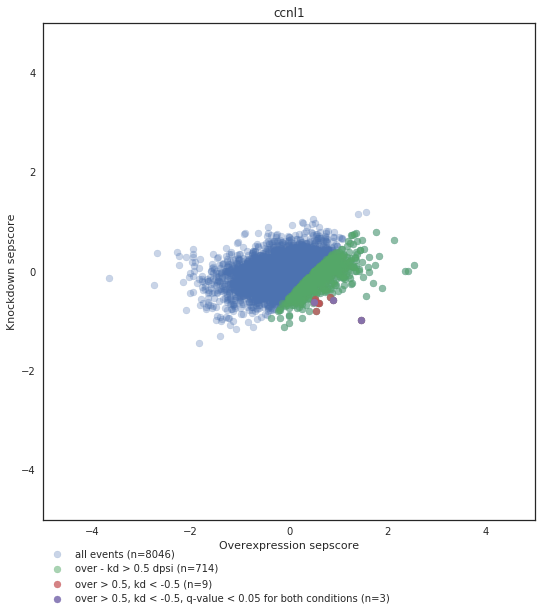

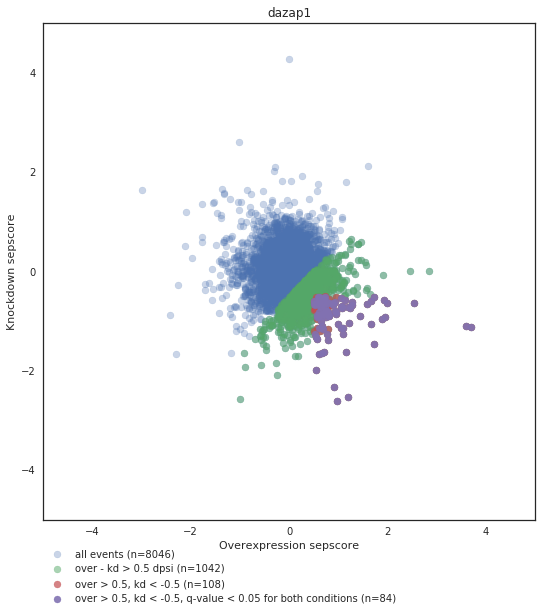

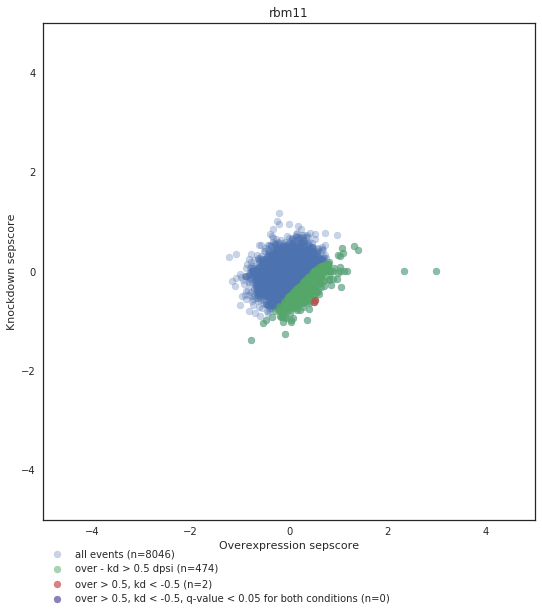

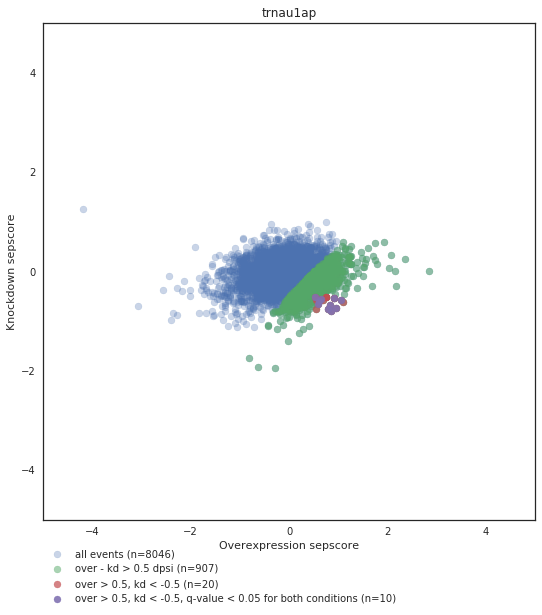

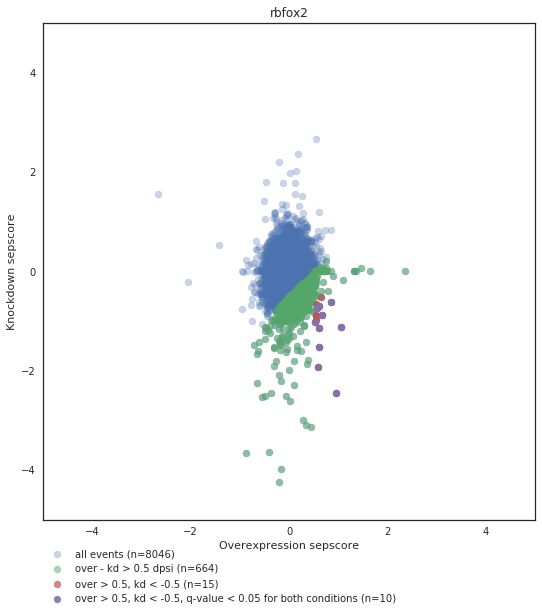

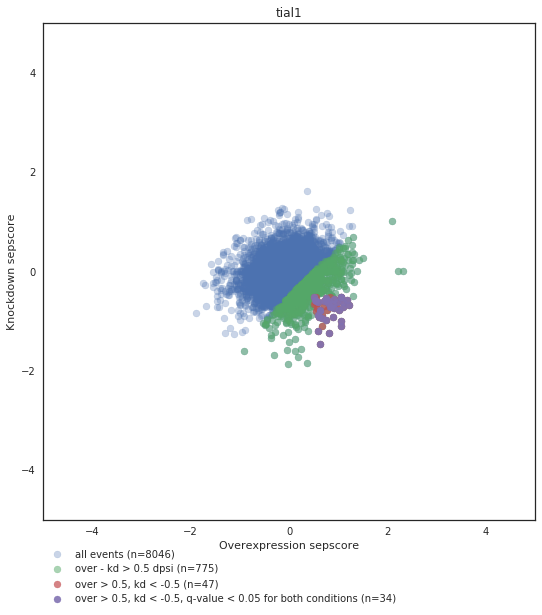

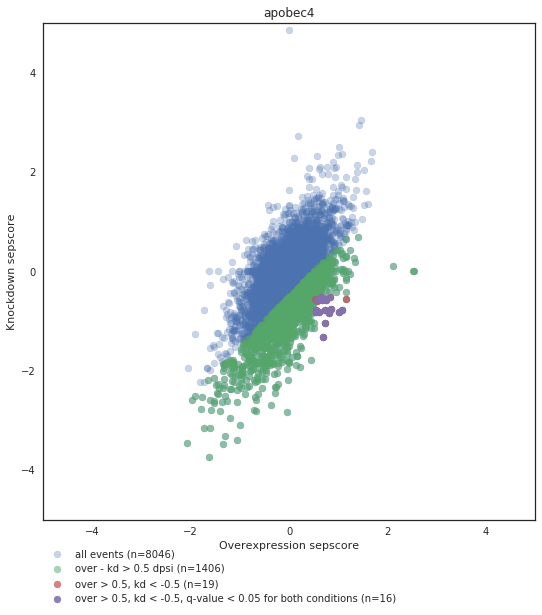

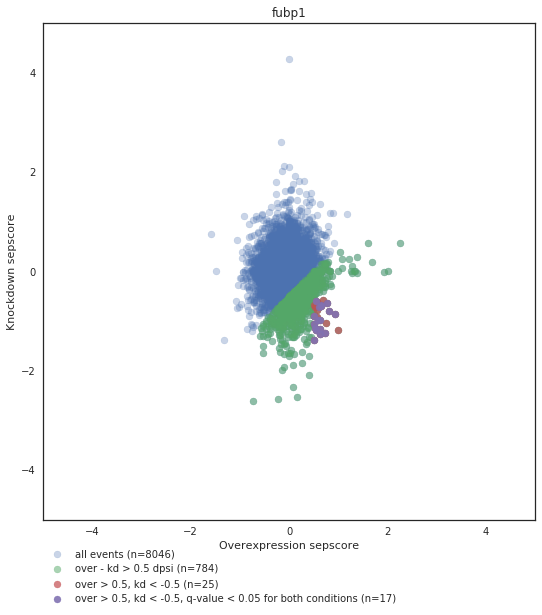

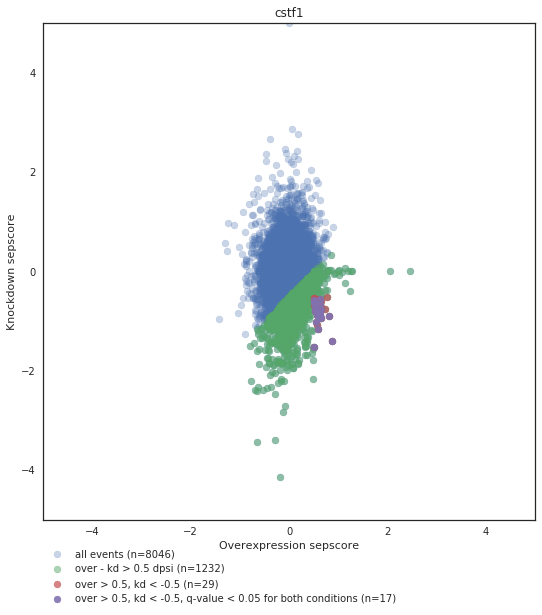

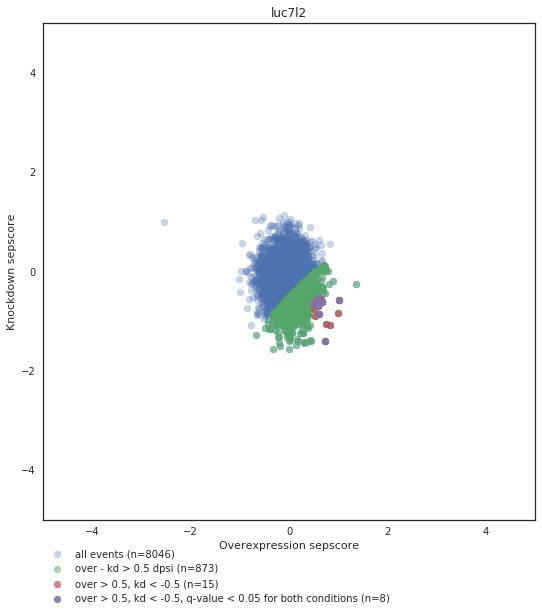

In [135]:
outdir = '/projects/ps-yeolab3/bay001/tbos/images/hta_psi_scatters/'
for rbp in c.keys():
    dfx = subset_dataframe_and_plot_dpsi(rbp, c)
    plot(dfx, outdir, rbp)
    # plt.clf()
    # plt.cla()

In [113]:
dpsi_diff = dfx[(dfx['over']-dfx['kd']>0.5)]

In [114]:
dpsi_diff

,over,overq,kd,kdq
10,0.486,0.282,-0.426,0.015
13,0.433,0.000,-0.379,0.072
20,0.506,0.000,-0.626,0.000
27,0.029,0.222,-0.587,0.000
37,0.154,0.305,-0.414,0.000
40,0.257,0.052,-0.339,0.090
41,0.200,0.000,-0.463,0.000
49,0.125,0.166,-0.448,0.034
51,0.338,0.101,-0.604,0.000
58,0.076,0.469,-0.484,0.000
